# Load data 

In [1]:
import torch
import torchvision 
import torchvision.transforms as transoforms
import torch.optim as optim
from documents.load_data import *
# from documents.load_data_SQ import *

from models import *
import torch.nn as nn
import torch.backends.cudnn as cudnn
import os 


%load_ext autoreload
%autoreload 2


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [2]:
# Data
print(device)
print('==> Preparing data..')
subject="ALL"
load=loader()

train_loader, test_loader,val_loader, _ = load(subject,batch_size= 30,num_validation = 30)

# cc=test_loader 
# dd=val_loader 
# test_loader=dd
# val_loader=cc

sub_num= 4 if subject=="ALL" else subject



cuda
==> Preparing data..
Train data shape:  (1845, 22, 1000)
Train labels shape:  (1845,)
test data shape:  (261, 22, 1000)
test labels shape:  (261,)
Validation data shape:  (270, 22, 1000)
Validation labels shape:  (270,)


In [3]:
# Training 
def train(epoch):
    trainloader=train_loader
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Get the inputs
        inputs, labels = inputs.to(device), labels.to(device).long()
        inputs = inputs.to(device)        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward+Backward+Optimize
        outputs = net(inputs)
#         labels = labels.unsqueeze(1)
#         print('labels',labels.shape)
#         one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#         labels=one_hot.to(device)
#         print('outputs',outputs.shape) # Shape should be [20*4]
#         print('labels',labels.shape)
        loss = criterion (outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics 
        train_loss += loss.item()
        _,predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return ([train_loss/(batch_idx+1),100.*correct/total])


In [4]:
# Testing
def test(epoch, testloader=test_loader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    total_by_cat = np.zeros((sub_num))
    correct_by_cat = np.zeros((sub_num))


    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
#             inputs, labels = inputs.to(device), labels.to(device)
            inputs,labels = inputs.to(device), labels.to(device).long()

            outputs = net(inputs)
#             labels=labels.unsqueeze(1)
            
#             one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#             labels=one_hot.to(device)
            
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            for i, (pred, tar) in enumerate(zip(predicted, labels)):
                total_by_cat[tar.item()]+=1
                if(pred.item() == tar.item()):
                    correct_by_cat[tar.item()] += 1
            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


    print('\nEpoch: %d | Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    np.set_printoptions(precision=3)
    print("Acc by class: ", correct_by_cat * 1.0 / total_by_cat)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc

    return [test_loss/(batch_idx+1),100.*correct/total]

In [5]:

# Main 
def main_train(epoches = 8):
    stats = {}
    stats['train'] = []
    stats['val']  = []
    stats['test'] = []
    epoches = range(epoches)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97, last_epoch=-1)

    for epoch in epoches:
        scheduler.step()
        stats['train'].append(train(epoch))
        stats['val'].append(test(epoch,testloader=val_loader))

#     stats['test']=test(epoch,test_loader)
#     print('Test set result:',stats['test'])

    stats['val']  = np.array(stats['val'])
    stats['train'] = np.array(stats['train'])

    fig, ax = plt.subplots(1, 2,figsize = (8,4))
    ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

    ax[0].legend(['validation','train'])
    ax[0].set_title('loss')

    ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

    ax[1].legend(['validation','train'])
    ax[1].set_title('accuracy')


In [6]:
# Model
from Model import Shallow_CNN
# from models import ShallowCNN,Shallow_CNN_SQ
from models import encoder,Transformer,EncoderRNN,RNN_CNN
# from models import RNN_CNN
print('==> Building model..')
# net = Shallow_CNN.CNN_Shallow()
# net=encoder.Model() # best59
# net = ShallowCNN.shallow_CNN()
# net = Transformer.Transformer0(cut=20, num_layers=6, heads=4, drop_out=0.1, max_relative_positions=0,)  # best 27 
# 可能是变厚的方式不靠谱，我希望是序列1000个，每20个采一个，也可能是层数太多
# net = Transformer.Transformer1(num_layers=1, heads=8, drop_out=0.1, max_relative_positions=0,) # best 39
# net = Transformer.Transformer1(num_layers=1, heads=1, drop_out=0.1, max_relative_positions=0,) # best 39
# net = Transformer.Transformer1(num_layers=1, heads=1, drop_out=0.5, max_relative_positions=0,) # best 39
net = EncoderRNN.EncoderRNN() # same as the above encoder.Model() 
# net = EncoderRNN.EncoderRNN1() # best 30
# net = Transformer.Transformer0(cut=10, num_layers=1, heads=4, drop_out=0.1, max_relative_positions=0,) # best 8 epoch 42
# net = Transformer.Transformer0(cut=2, num_layers=1, heads=4, drop_out=0.1, max_relative_positions=0,) #大约10epoch过拟合，最好50
# 不知道是折叠策略不对，还是折叠无效，less is more,放弃折叠
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=2, drop_out=0.1, max_relative_positions=0,) # 只跑了20轮 第19 51
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=1, drop_out=0.1, max_relative_positions=0,) #只跑了20轮 47
# net = Transformer.Transformer0(cut=1, num_layers=1, heads=2, drop_out=0.1, max_relative_positions=20,) # 很慢，第一第二轮都是25
# 怀疑是实现错了

# 以上transformer都还没有调优化器，一般transformer要设置 warmup， 我觉得不设的话lr调小或者decay变大
# net =  RNN_CNN.RNN0_CNN() # 前20轮 14 69.7 
# net =RNN_CNN.RNN0_CNN(rnn_num_layers=1, rnn_dropout=0.3)  # 前20轮18 67 和上面相似，loss在第五个epoch过拟合
# net =RNN_CNN.RNN0_CNN(rnn_num_layers=2, rnn_dropout=0.1) # 感觉这三个acc都波动很大，建议调低lr 13epoch 67
# net =  RNN_CNN.RNN0_CNN(rnn_num_layers=1, rnn_dropout=0) # 把lr调低到0.0001试下，好像在64附近挣扎
# net= Shallow_CNN_SQ.CNN_Shallow()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.t7')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     # start_epoch = checkpoint['epoch']

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


==> Building model..


EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 30, 22])
EncoderRNN before gru x size torch.Size([1000, 3

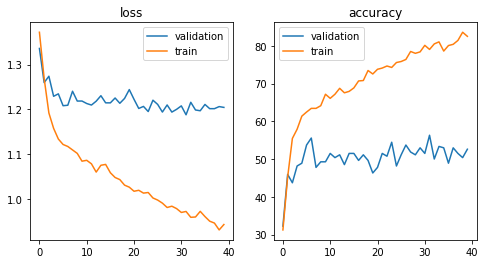

In [7]:
import matplotlib.pyplot as plt
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.002)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01) #SQ

main_train(epoches = 40)

In [8]:
net

DataParallel(
  (module): EncoderRNN(
    (drop_out): Dropout(p=0.3)
    (softmax): Softmax()
    (classifier): Linear(in_features=22, out_features=4, bias=True)
    (gru): GRU(22, 22, num_layers=2, bidirectional=True)
    (linear): Linear(in_features=22000, out_features=22, bias=True)
    (relu): ReLU()
  )
)

how to  

In [9]:
def load_checkpoint(model, checkpoint_PATH, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_PATH)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
    return model, optimizer

In [10]:
# net,acc,epoch=net.load_state_dict(torch.load('C:/Users/Guangyuan Zhao/Documents/GitHub/ECE239as-Deep-learning/checkpoint/ckpt.t7'))

checkpoint_PATH='D:\Deep learning\checkpoint/ckpt.t7'
model_CKPT = torch.load(checkpoint_PATH)
net.load_state_dict(model_CKPT['net'])



In [11]:
epoch=4
test(epoch,test_loader)


EncoderRNN before gru x size torch.Size([1000, 50, 22])
EncoderRNN before gru x size torch.Size([1000, 50, 22])
EncoderRNN before gru x size torch.Size([1000, 50, 22])
EncoderRNN before gru x size torch.Size([1000, 50, 22])
EncoderRNN before gru x size torch.Size([1000, 50, 22])
EncoderRNN before gru x size torch.Size([1000, 11, 22])

Epoch: 4 | Test Loss: 1.204 | Acc: 46.743% (122/261)
Acc by class:  [0.6   0.379 0.407 0.47 ]


[1.2038750648498535, 46.74329501915709]

In [12]:
# print(model_CKPT['epoch'],model_CKPT['acc'])
print('VAL Acc: %.3f%%'
    % (model_CKPT['acc']))

VAL Acc: 56.296%
